In [2]:
%pylab inline

import numpy as np
print np.__version__

# Matplotlib things
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Show matplotlib version
import matplotlib
print matplotlib.__version__

# Scipy
import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

# Reading data
#import glob
import h5py
import pandas as pd

# LAL stuff
import lal
import lalsimulation

Populating the interactive namespace from numpy and matplotlib
1.15.4
2.2.2


In [9]:
sys.path.insert(0, '/Users/lackey/Research/eosinference/src')

import utilities as util
import eospiecewisepolytrope

In [4]:
sys.path.insert(0, '/Users/lackey/Research/gpsurrogate/src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2 as f2
import gaussianprocessregression as gpr
import designofexperiment as doe
#import pycbcwaveform as pycbcwave
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics
import fisher

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(f2)
imp.reload(gpr)
imp.reload(doe)
#imp.reload(pycbcwave)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)
imp.reload(fisher)

import constants
imp.reload(constants)
from constants import *

In [5]:
import seaborn as sns
cp = sns.color_palette('colorblind', 6)

matplotlib.rcParams['figure.figsize'] = (9.7082039325, 6.0)
matplotlib.rcParams['xtick.labelsize'] = 20.0
matplotlib.rcParams['ytick.labelsize'] = 20.0
matplotlib.rcParams['axes.labelsize'] = 25.0
matplotlib.rcParams['legend.fontsize'] = 17.0
matplotlib.rcParams['font.family']= 'Times New Roman'
matplotlib.rcParams['font.sans-serif']= ['Bitstream Vera Sans']
matplotlib.rcParams['text.usetex']= True
matplotlib.rcParams['mathtext.fontset']= 'stixsans'

# Get PSD

(1e-25, 1e-19)

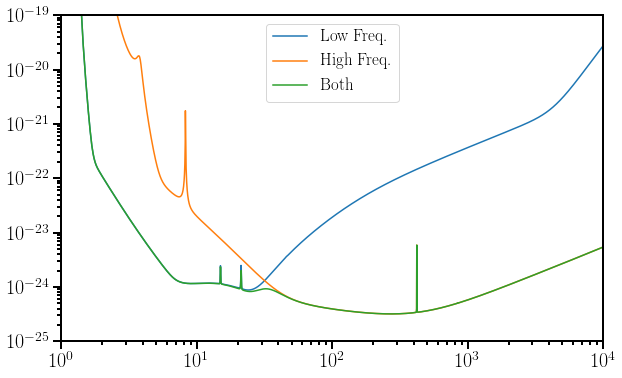

In [6]:
# The file is actually an ASD not a PSD
psd_array = np.loadtxt('../data/ET_D_data.txt') 
psd_array[:, 1] = psd_array[:, 1]**2
psd_array[:, 2] = psd_array[:, 2]**2
psd_array[:, 3] = psd_array[:, 3]**2

psd_array_etd = psd_array[:, [0, 3]]

fig, axes = plt.subplots()

axes.plot(psd_array[:, 0], psd_array[:, 1]**0.5, label='Low Freq.')
axes.plot(psd_array[:, 0], psd_array[:, 2]**0.5, label='High Freq.')
axes.plot(psd_array[:, 0], psd_array[:, 3]**0.5, label='Both')

axes.legend()
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlim(1, 10000)
axes.set_ylim(1.0e-25, 1.0e-19)

# Parameterized fits for several EOS models

In [11]:
eos_fits = {
'apr4': [34.269, 2.830, 3.445, 3.348], # R14 = 11.428km
'sly': [34.384, 3.005, 2.988, 2.851], # R14 = 11.736km
'mpa1':[34.495, 3.446, 3.572, 2.887], # R14 = 12.473km
'h4':  [34.669, 2.909, 2.246, 2.144], # R14 = 13.774km
'ms1b':[34.855, 3.456, 3.011, 1.425], # R14 = 14.583km
'ms1': [34.858, 3.224, 3.033, 1.325] # R14 = 14.918km
}

m = 1.4
for key in eos_fits.keys():
    print key
    eos_params = np.array(eos_fits[key])
    eos = eospiecewisepolytrope.EOS4ParameterPiecewisePolytropeGammaParams(eos_params)
    print eos.mmax, eos.radiusofm(m), eos.k2ofm(m), eos.lambdaofm(m)

ms1b
None 14.5285819378 0.107136146198 1224.53032
sly
None 11.7065225752 0.0761705689954 295.695096052
ms1
None 14.9268089298 0.105434060118 1379.53647175
apr4
None 11.3201124148 0.0754547238283 247.660941466
h4
None 13.9526953719 0.0916161109992 855.42079185
mpa1
None 12.4347478279 0.0912890105698 479.20440243


In [67]:
def lambda_of_m_curve(eos_params):
    """
    """
    eos = eospiecewisepolytrope.EOS4ParameterPiecewisePolytropeGammaParams(eos_params)
    
    mmax = eos.max_mass()
    
    ms = np.linspace(0.5, mmax, 100)
    lambda_eos = np.array([eos.lambdaofm(m) for m in ms])
    radius_eos = np.array([eos.radiusofm(m) for m in ms])

    return ms, lambda_eos, radius_eos

# Universal relations fit

In [62]:
def compactness_fit(lam):
    """Fit from K. Yagi, N. Yunes. Physics Reports 681 (2017).
    Eq. 78. with Yagi's coefficients not Maselli's coefficients.
    Maximum error for compactness is claimed to be +/-6.5% (excluding quark stars).
    """
    a0 = 0.360
    a1 = -0.0355
    a2 = 0.000705
    ln_lam = np.log(lam)
    return a0 + a1*ln_lam + a2*ln_lam**2


def radius_fit(mass, lam):
    """Radius using compactness fit.
    """
    cfit = compactness_fit(lam)
    radius = (lal.G_SI*lal.MSUN_SI*mass) / (lal.C_SI**2 * cfit)
    return radius*1.0e-3


def delta_lambda_tilde_fit(q, lamt):
    """Fit for delta_lambda_tilde given the mass ratio q<=1 and lambda_tilde.
    From K. Yagi, N. Yunes. CQG 34, 015006 (2017).
    Eqs. 9 and 11, with coefficients from Table 3.
    Claimed accuracy is 25% for masses below 1.6Msun?
    Compare results to Figure 7.
    """
    n = 0.743
    alpha = -1.0
    a = 0.07319

    b11 = -3.598
    b12 = 1.773
    b21 = 18.50
    b22 = -10.84
    b31 = -30.45
    b32 = 42.60

    c11 = -1.925
    c12 = -0.2747
    c21 = 4.788
    c22 = 9.178
    c31 = -1.240
    c32 = -13.55

    x = 1.0/lamt
    x_15 = x**(1.0/5.0)
    
    def N1(q):
        return -(1319.0 - 7996.0*q - 11005.0*q**2)
    
    def N2(q): 
        return 12.0*q + 1.0

    B = ( 1.0 - q**(10.0/(3.0-n)) ) / ( 1.0 + q**(10.0/(3.0-n)) )
    num1 = (1.0 - B)*N1(q) - (1.0 + B)*q**6*N1(1.0/q)
    den1 = (1.0 - B)*N2(q) + (1.0 + B)*q**5*N2(1.0/q)
    F_n_dlt = -(13.0/21104.0) * (1.0/(1.0+q)) * num1/den1

    num = a
    num += b11*q*x_15 + b12*q**2*x_15
    num += b21*q*x_15**2 + b22*q**2*x_15**2
    num += b31*q*x_15**3 + b32*q**2*x_15**3

    den = a
    den += c11*q*x_15 + c12*q**2*x_15
    den += c21*q*x_15**2 + c22*q**2*x_15**2
    den += c31*q*x_15**3 + c32*q**2*x_15**3

    return F_n_dlt * x**alpha * num / den

# Wrapper function for TaylorF2 waveform

In [13]:
def taylorf2_fisher_params(params, f_min, f_max, npoints=1000):
    """Wrapper for TaylorF2 with Fisher-matrix parameters.
    phase_order=4 corresponds to 2PN order.
    
    The reference phase is defined to be 0 at f_max.
    """
    #print params
    lndist, f0tc, phic, lnmc, q, ssym, santi, tlambda, dtlambda = params
    
    distance = np.exp(lndist)
    mc = np.exp(lnmc)
    eta = q/(1.0+q)**2
    mass1 = fisher.m1_of_mchirp_eta(mc, eta)
    mass2 = fisher.m2_of_mchirp_eta(mc, eta)
    mtot = mass1+mass2
    spin1z, spin2z = fisher.s1_s2_of_pe_params(ssym, santi)
    lambda1, lambda2 = fisher.lam1_lam2_of_pe_params(eta, tlambda, dtlambda)
    
    #print mass1, mass2, spin1z, spin2z, lambda1, lambda2
    
    # Calculate waveform
    fs = np.logspace(np.log10(f_min), np.log10(f_max), npoints)
    mfs = f_to_mf(fs, mtot)

    h_dim = f2.dimensionless_taylorf2_waveform(
    mf=mfs, 
    q=q, spin1z=spin1z, spin2z=spin2z, lambda1=lambda1, lambda2=lambda2,
    quad1=1.0, quad2=1.0, spin_spin=True)
    
    h = wave.dimensionless_to_physical_freq(h_dim, mtot, distance)
    
    # Convert to h = F+h+ + i Fxhx
    # TODO: Do this correctly, accounting for all the angles
    h.amp /= 2.0
    
    # Set the phase at the last data point to phic
    h.phase += phic - h.phase[-1]
    
    # Shift the coalescence time by f0tc (add 2 \pi f f0tc to Fourier transformed phase)
    h.phase += 2.*np.pi*h.x*f0tc
    
    return h

# Functions for Fisher matrix and generating samples

In [53]:
def get_covariance_matrix(df_inj, i, f_min=1.0):
    
    # Extract parameters from DataFrame
    dist, m1, m2, mc, q, lambdat, dlambdat = df_inj.loc[i, ['dist', 'm1', 'm2', 'mc', 'q', 'lambdat', 'dlambdat']]
    
    # Bounds of integration
    f_max = f_isco(m1 + m2)
    print f_min, f_max
    
    # The Fisher matrix parameters
    lndist = np.log(dist)
    f0tc = 0.0
    phic = 0.0
    lnmc = np.log(mc)
    spin1z = 0.0
    spin2z = 0.0
    ssym = fisher.ssym_of_s1_s2(spin1z, spin2z)
    santi = fisher.santisym_of_s1_s2(spin1z, spin2z)
    params = (lndist, f0tc, phic, lnmc, q, ssym, santi, lambdat, dlambdat)
    
    param_indices = [1, 2, 3, 4, 5, 6, 7]
    dthetas = [0, 0.001, 0.1, 0.001, 0.01, 0.05, 0.01, 10.0, 0]
    dtypes = ['central', 'central', 'central', 'backward', 'central', 'central', 'forward']
    prior_sigmas = [None, None, None, None, 0.05, 0.05, None]
    
    fisher_f2 = fisher.NumericalFisher(taylorf2_fisher_params, params, f_min, f_max, psd_array_etd)
    snr = fisher_f2.snr()
    fisher_f2.derivative_list_eval(param_indices, dthetas, dtypes)
    fisher_f2.fisher_matrix()
    fisher_f2.prior_matrix(prior_sigmas)
    cov = fisher_f2.covariance_matrix()
    stat_err = fisher_f2.get_sigmas()
    
    mean = np.array([f0tc, phic, lnmc, q, ssym, santi, lambdat])
    return snr, stat_err, mean, cov

In [70]:
def generate_samples(mean, cov, ntry=10000, lam_lim=1.0):
    # Draw from multivariate Gaussian
    samples = np.random.multivariate_normal(mean, cov, ntry)
    
    df = pd.DataFrame(data=samples, columns=['f0tc', 'phic', 'lnmc', 'q', 'ssym', 'santi', 'lambdat'])
    
    # Truncate q>1.0
    df = df[(df['q']<=1.0) & (df['q']>0.0)]
    
    # Fill in mass parameters
    mc = np.exp(df['lnmc'].values)
    q = df['q'].values
    eta = fisher.eta_of_q(q)
    m1 = fisher.m1_of_mchirp_eta(mc, eta)
    m2 = fisher.m2_of_mchirp_eta(mc, eta)
    
    # Fill in tidal parameters using universal relations fit
    lambdat = df['lambdat'].values
    dlambdat_fit = delta_lambda_tilde_fit(q, lambdat)
    lambda1_fit, lambda2_fit = util.lam1_lam2_of_pe_params(eta, lambdat, dlambdat_fit)
    # dlambdat should be >=0. Errors in the fit cause it to be negative sometimes.
    # This leads to negative lambda1, lambda2 values.
    lambda1_fit[lambda1_fit<=lam_lim] = lam_lim
    lambda2_fit[lambda2_fit<=lam_lim] = lam_lim
    
    # Fill in radius with fit
    r1_fit = radius_fit(m1, lambda1_fit)
    r2_fit = radius_fit(m2, lambda2_fit)
    
    df['mc'] = mc
    df['eta'] = eta
    df['m1'] = m1
    df['m2'] = m2
    df['dlambdat_fit'] = dlambdat_fit
    df['lambda1_fit'] = lambda1_fit
    df['lambda2_fit'] = lambda2_fit
    df['r1_fit'] = r1_fit
    df['r2_fit'] = r2_fit
    
    # Sanitize the samples
    df = df[(df['m1']>=0.5) & (df['m1']<=3.2) & (df['m2']>=0.5) & (df['m2']<=3.2)]
    df = df[(df['lambda1_fit']>=lam_lim) & (df['lambda1_fit']<=5000) & (df['lambda2_fit']>=lam_lim) & (df['lambda2_fit']<=5000)]
    
    return df

# Create population of events

In [55]:
def sample_bns_population(mmin=1.0, mmax=1.8, qmin=0.7):
    """
    """
    while True:
        # Sample 2 masses 
        ms = np.random.uniform(low=mmin, high=mmax, size=2)
        m1 = np.max(ms)
        m2 = np.min(ms)
        q = m2/m1
        if q>=qmin:
            return {'m1':m1, 'm2':m2, 'q':q}

In [84]:
nbns = 10
eos_key = 'sly'
distance = 400

# Sample masses for injected BNS systems
d = [sample_bns_population(mmin=1.0, mmax=1.8, qmin=0.7) for n in range(nbns)]
df_inj = pd.DataFrame(data=d)

# Choose EOS
eos_params = np.array(eos_fits[eos_key])
eos = eospiecewisepolytrope.EOS4ParameterPiecewisePolytropeGammaParams(eos_params)

# Fill in the remaining data
df_inj['dist'] = distance
df_inj['mc'] = np.nan
df_inj['eta'] = np.nan
df_inj['lambda1'] = np.nan
df_inj['lambda2'] = np.nan
df_inj['lambdat'] = np.nan
df_inj['dlambdat'] = np.nan
df_inj['r1'] = np.nan
df_inj['r2'] = np.nan
for i in range(len(df_inj)):
    m1 = df_inj.loc[i, 'm1']
    m2 = df_inj.loc[i, 'm2']
    mc = fisher.mchirp_of_m1_m2(m1, m2)
    q = m2/m1
    eta = fisher.eta_of_m1_m2(m1, m2)
    lambda1 = eos.lambdaofm(m1)
    lambda2 = eos.lambdaofm(m2)
    r1 = eos.radiusofm(m1)
    r2 = eos.radiusofm(m2)
    lambdat = fisher.lamtilde_of_eta_lam1_lam2(eta, lambda1, lambda2)
    dlambdat = fisher.deltalamtilde_of_eta_lam1_lam2(eta, lambda1, lambda2)
    df_inj.loc[i, 'mc'] = mc
    df_inj.loc[i, 'q'] = q
    df_inj.loc[i, 'eta'] = eta
    df_inj.loc[i, 'lambda1'] = lambda1
    df_inj.loc[i, 'lambda2'] = lambda2
    df_inj.loc[i, 'lambdat'] = lambdat
    df_inj.loc[i, 'dlambdat'] = dlambdat
    df_inj.loc[i, 'r1'] = r1
    df_inj.loc[i, 'r2'] = r2

df_inj

,m1,m2,q,dist,mc,eta,lambda1,lambda2,lambdat,dlambdat,r1,r2
0,1.297665,1.147115,0.883984,400,1.061729,0.249052,484.566154,1026.614347,710.489642,63.252732,11.762449,11.823581
1,1.526940,1.524978,0.998715,400,1.328424,0.250000,161.273603,162.793338,162.032105,0.204625,11.614557,11.616208
2,1.443663,1.364286,0.945017,400,1.221645,0.249800,239.991582,350.986238,291.159519,14.150618,11.678064,11.727643
3,1.293392,1.074803,0.830996,400,1.025538,0.247870,494.771801,1496.075989,872.115747,111.603860,11.764495,11.846818
4,1.424659,1.251591,0.878520,400,1.161980,0.248955,262.793599,607.409695,404.750028,41.814197,11.690825,11.783450
5,1.642106,1.394521,0.849227,400,1.316490,0.248338,92.454633,303.558751,174.348451,26.917657,11.501342,11.709883
6,1.521592,1.125935,0.739971,400,1.136891,0.244417,165.449734,1144.851370,463.622542,103.897713,11.619038,11.830693
7,1.434766,1.040419,0.725149,400,1.060894,0.243654,250.406529,1798.014471,705.253354,156.413659,11.684113,11.857027
8,1.520831,1.256573,0.826241,400,1.202357,0.247737,166.052958,592.667956,324.459303,50.891687,11.619672,11.781288
9,1.191387,1.072158,0.899924,400,0.983624,0.249306,819.917601,1517.201057,1119.154625,79.347415,11.807695,11.847618


# Calculate Fisher matrix for each BNS event

In [85]:
mean_list = []
cov_list = []
for i in range(len(df_inj)):
    snr, stat_err, mean, cov = get_covariance_matrix(df_inj, i, f_min=1.0)
    print i
    print snr
    print stat_err
    mean_list.append(mean)
    cov_list.append(cov)

1.0 1798.5977549315353
0
113.31604091358344
[7.06056627e-05 1.30192600e+00 1.16966885e-06 2.51191877e-02
 4.37141007e-04 1.58077550e-02 4.33115241e+01]
1.0 1440.7904366162243
1
136.3447956010745
[5.62220555e-05 8.07591915e-01 5.30999423e-07 2.18806222e-01
 3.44784388e-04 4.99827651e-02 2.59960186e+01]
1.0 1565.9734394391132
2
127.2377918956383
[6.54595631e-05 1.01097523e+00 1.21577776e-06 5.33872297e-02
 4.05318293e-04 3.15529416e-02 3.29380611e+01]
1.0 1856.7624341565147
3
110.11518298779762
[7.16964073e-05 1.37953335e+00 1.13567699e-06 1.57357355e-02
 4.41317438e-04 1.04781112e-02 4.59772278e+01]
1.0 1643.035581131161
4
122.08535130835627
[6.95763451e-05 1.13127410e+00 1.34135270e-06 2.57858043e-02
 4.34978010e-04 1.61108192e-02 3.70730656e+01]
1.0 1448.0455981608113
5
135.31907331705023
[6.85743615e-05 9.38144210e-01 1.62368959e-06 2.22474865e-02
 4.34061083e-04 1.41346674e-02 3.01433387e+01]
1.0 1660.8610669391992
6
119.86750041279902
[7.13592712e-05 1.17324533e+00 1.35082202e-06 9

# Draw samples from fisher matrix and save to file

In [86]:
df_samples_list = []
for i in range(len(df_inj)):
    df = generate_samples(mean_list[i], cov_list[i], ntry=10000)
    print df.shape
    df.to_csv('../data/BNS_{}.csv'.format(i), index=False)
    df_samples_list.append(df)

(10000, 16)
(4954, 16)
(8516, 16)
(10000, 16)
(10000, 16)
(10000, 16)
(10000, 16)
(10000, 16)
(10000, 16)
(9998, 16)


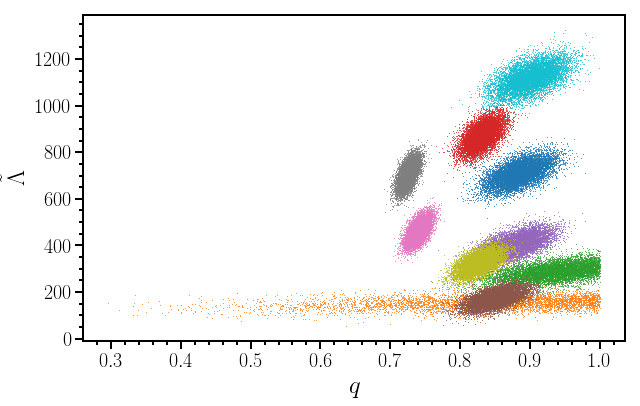

In [100]:
fig, ax = plt.subplots()

for i in range(len(df_samples_list)):
    df = df_samples_list[i]
    x, y = df['q'].values, df['lambdat'].values
    ax.scatter(x, y, s=1, lw=0)

    
#ax.set_xlim(7, 15)
#ax.set_ylim(0.5, 3)
ax.set_xlabel(r'$q$')
ax.set_ylabel(r'$\tilde\Lambda$')
ax.minorticks_on()

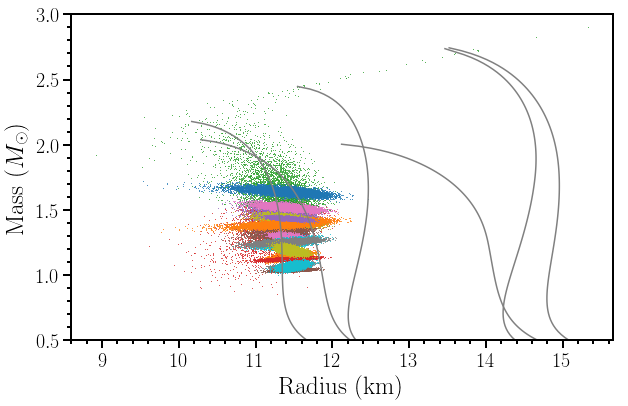

In [87]:
fig, ax = plt.subplots()

for i in range(len(df_samples_list)):
    df = df_samples_list[i]
    x, y = df['r1_fit'].values, df['m1'].values
    ax.scatter(x, y, s=1, lw=0)
    x, y = df['r2_fit'].values, df['m2'].values, 
    ax.scatter(x, y, s=1, lw=0)

for key in ['apr4', 'sly', 'mpa1', 'h4', 'ms1b', 'ms1']:
    eos_params = np.array(eos_fits[key])
    ms, lambda_eos, radius_eos = lambda_of_m_curve(eos_params)
    ax.plot(radius_eos, ms, lw=1.5, c='gray')
    
#ax.set_xlim(7, 15)
ax.set_ylim(0.5, 3)
ax.set_xlabel(r'Radius (km)')
ax.set_ylabel(r'Mass ($M_\odot$)')
ax.minorticks_on()

(7, 15)

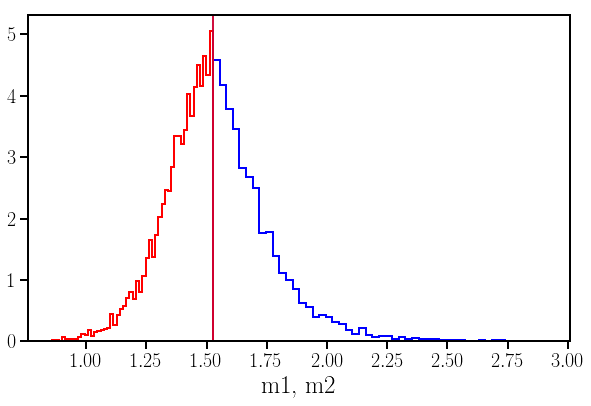

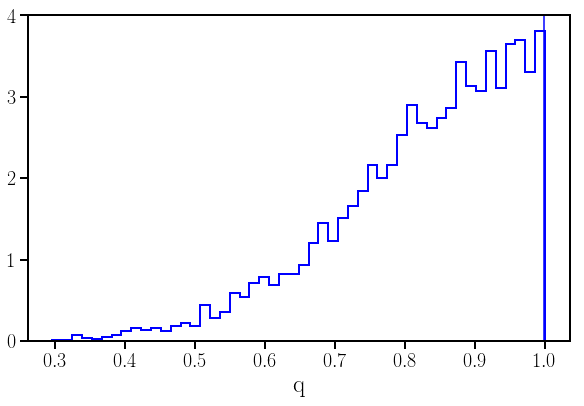

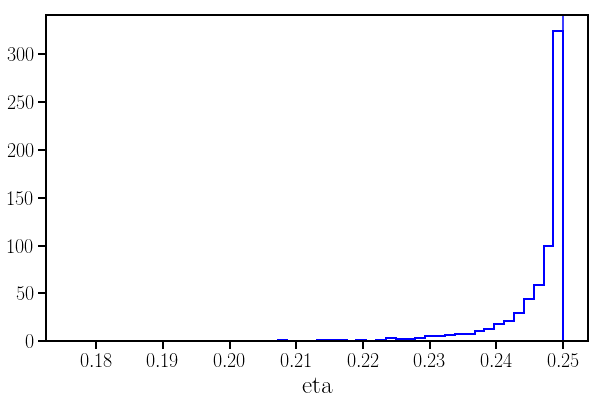

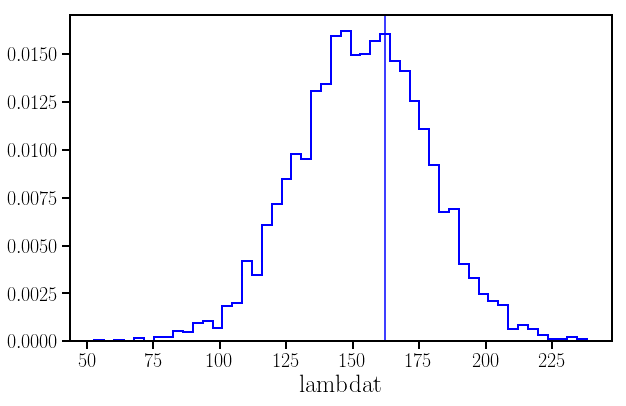

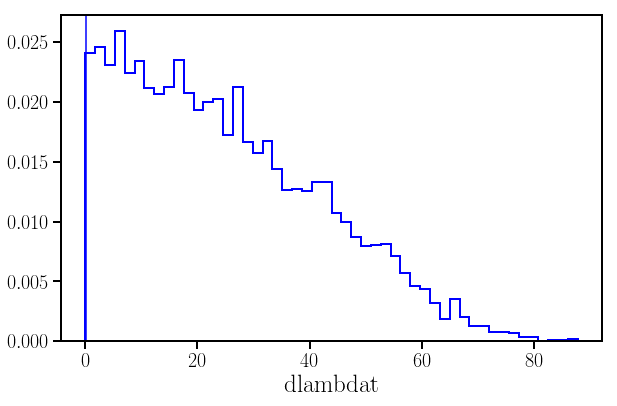

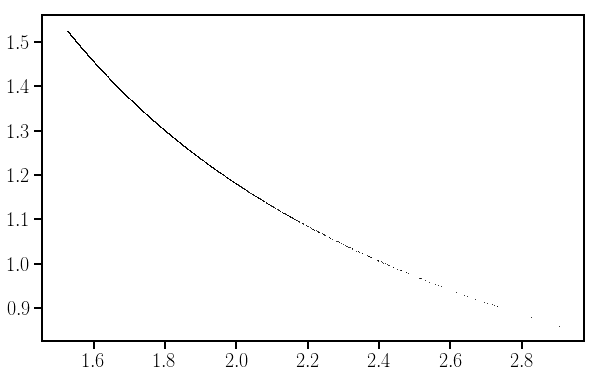

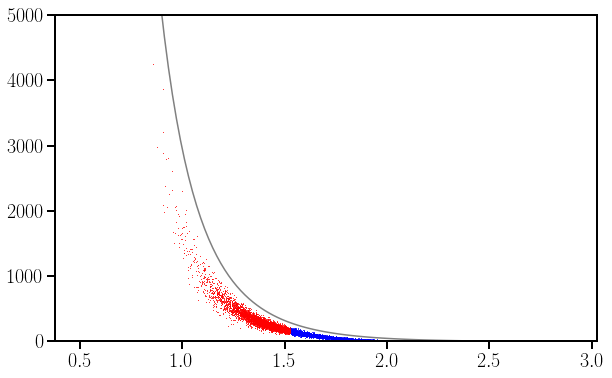

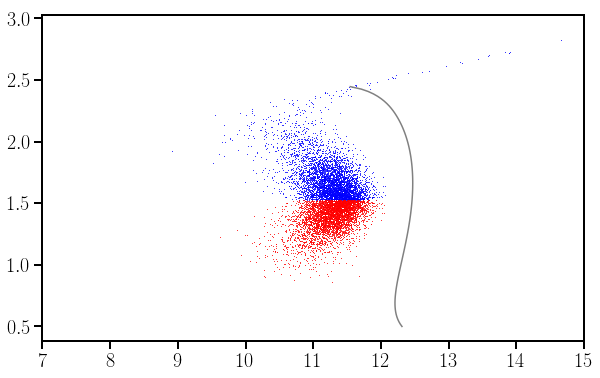

In [101]:
i = 1
df = df_samples_list[i]

fig, ax = plt.subplots()
column = 'm1'
x = df[column].values
x_inj = df_inj.loc[i, column]
ax.hist(x, bins=50, density=True, histtype='step', lw=2, color='b')
ax.axvline(x_inj, c='b')
ax.set_xlabel('m1, m2')

column = 'm2'
x = df[column].values
x_inj = df_inj.loc[i, column]
ax.hist(x, bins=50, density=True, histtype='step', lw=2, color='r')
ax.axvline(x_inj, c='r')

column = 'q'
fig, ax = plt.subplots()
x = df[column].values
x_inj = df_inj.loc[i, column]
ax.hist(x, bins=50, density=True, histtype='step', lw=2, color='b')
ax.axvline(x_inj, c='b')
ax.set_xlabel(column)

column = 'eta'
fig, ax = plt.subplots()
x = df[column].values
x_inj = df_inj.loc[i, column]
ax.hist(x, bins=50, density=True, histtype='step', lw=2, color='b')
ax.axvline(x_inj, c='b')
ax.set_xlabel(column)

column = 'lambdat'
fig, ax = plt.subplots()
x = df[column].values
x_inj = df_inj.loc[i, column]
ax.hist(x, bins=50, density=True, histtype='step', lw=2, color='b')
ax.axvline(x_inj, c='b')
ax.set_xlabel(column)

column = 'dlambdat'
fig, ax = plt.subplots()
x = df['dlambdat_fit'].values
x_inj = df_inj.loc[i, column]
ax.hist(x, bins=50, density=True, histtype='step', lw=2, color='b')
ax.axvline(x_inj, c='b')
ax.set_xlabel(column)

fig, ax = plt.subplots()
x, y = df['m1'].values, df['m2'].values
ax.scatter(x, y, s=1, facecolor='k', lw=0)


fig, ax = plt.subplots()
x, y = df['m1'].values, df['lambda1_fit'].values
ax.scatter(x, y, s=1, facecolor='b', lw=0)
x, y = df['m2'].values, df['lambda2_fit'].values
ax.scatter(x, y, s=1, facecolor='r', lw=0)
eos_params = np.array(eos_fits['mpa1'])
ms, lambda_eos, radius_eos = lambda_of_m_curve(eos_params)
ax.plot(ms, lambda_eos, lw=1.5, c='gray')
ax.set_ylim(0, 5000)

fig, ax = plt.subplots()
x, y = df['r1_fit'].values, df['m1'].values
ax.scatter(x, y, s=1, facecolor='b', lw=0)
x, y = df['r2_fit'].values, df['m2'].values, 
ax.scatter(x, y, s=1, facecolor='r', lw=0)
eos_params = np.array(eos_fits['mpa1'])
ms, lambda_eos, radius_eos = lambda_of_m_curve(eos_params)
ax.plot(radius_eos, ms, lw=1.5, c='gray')
ax.set_xlim(7, 15)

# Make contour plots

In [332]:
def rm_contour_data(df):
    #gridsize = 100
    gridsize = 250
    
    x, y = df['r1_fit'].values, df['m1'].values
    kde_bound_limits = [0, 20, y.min(), 3.0]
    grid_limits = [x.min()-0.1, x.max()+0.1, y.min()-0.1, y.max()+0.1]
    print grid_limits
    cd1 = util.estimate_2d_post(x, y, kde_bound_limits, grid_limits, gridsize=gridsize)
    
    x, y = df['r2_fit'].values, df['m2'].values
    kde_bound_limits = [0, 20, 0.5, y.max()]
    grid_limits = [x.min()-0.1, x.max()+0.1, y.min()-0.1, y.max()+0.1]
    print grid_limits
    cd2 = util.estimate_2d_post(x, y, kde_bound_limits, grid_limits, gridsize=gridsize)
    
    return {'cd1':cd1, 'cd2':cd2}

In [333]:
cds_list = []
for i in range(len(df_samples_list)):
    print i
    df = df_samples_list[i]
    cds = rm_contour_data(df)
    cds_list.append(cds)

0
[10.866240004605906, 11.948523607379357, 1.0487285716861525, 1.4142647068678003]
[10.869083558147313, 11.949643658604128, 0.907534862193723, 1.2486584113296197]
1
[9.110051053351816, 12.345223611039252, 1.449030684663402, 1.8844313009395008]
[9.546900594885347, 12.341589911132715, 1.2499271539285852, 1.6490270082636118]
2
[10.388149961393943, 12.184227808113432, 1.3356772409227384, 1.6613680784788707]
[10.372910325781277, 12.166098190307677, 1.1029610564731969, 1.4044225822512633]
3
[10.721575414305786, 11.982450192273946, 1.2247242031662222, 1.6659139801962317]
[10.697148729526912, 11.973761854111112, 1.0267381149970147, 1.4247080304675768]


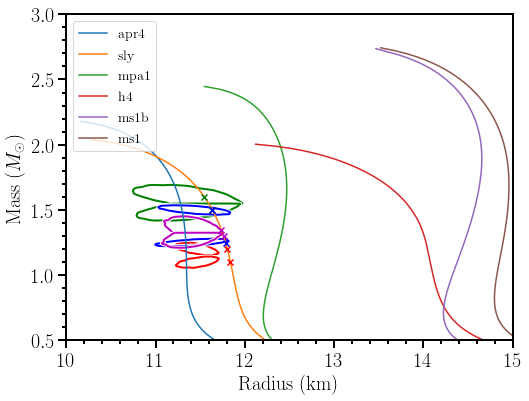

In [343]:
fig, ax = plt.subplots()

for i, c in zip([0, 1, 2, 3], ['r', 'g', 'b', 'm']):
    cds = cds_list[i]
    cd1 = cds['cd1']
    cd2 = cds['cd2']
    
    util.plot_posterior_with_contours(
        ax, cd1, cmap=None, levels=[90], 
        linewidths=[2], linestyles=['-'], 
        colors=[c], white_contour_back=True)
    
    util.plot_posterior_with_contours(
        ax, cd2, cmap=None, levels=[90], 
        linewidths=[2], linestyles=['-'], 
        colors=[c], white_contour_back=True)

    ax.scatter([df_inj.loc[i, 'r1'], df_inj.loc[i, 'r2']], [df_inj.loc[i, 'm1'], df_inj.loc[i, 'm2']], 
               marker='x', color=c, zorder=10)
    
for key in ['apr4', 'sly', 'mpa1', 'h4', 'ms1b', 'ms1']:
    eos_params = np.array(eos_fits['mpa1'])
    ms, lambda_eos, radius_eos = lambda_of_m_curve(eos_params)
    ax.plot(radius_eos, ms, lw=1.5, label=key)
    
ax.set_xlim(10, 15)
ax.set_ylim(0.5, 3)
ax.set_xlabel(r'Radius (km)')
ax.set_ylabel(r'Mass ($M_\odot$)')
ax.minorticks_on()
ax.legend(loc='upper left')
#fig.savefig('mr.pdf', format='pdf', transparent=True, bbox_inches='tight')